In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

In [2]:
# Get .nwb file

# ALWAYS RUN THIS CELL
# widen jupyter notebook window
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

from face_rhythm.util import helpers, setup
from pathlib import Path

# General Parameters
overwrite_config = False
remote           = False # Select true if running on any system where your kernel isn't on your local machine
trials           = False # Let us know if you're using trials and want to use them as a dimension in the factorization
multisession     = False # Set to true if you're doing a multisession analysis

# Project path, video path, and (optionally) run name
project_path     = Path(r'/media/rich/bigSSD RH/other lab data/uchida lab/sara/run2').resolve() # often Path.cwd().resolve() is useful
video_path       = Path(r'/media/rich/bigSSD RH/other lab data/uchida lab/sara').resolve() 
run_name         = 'new'

config_filepath = setup.setup_project(project_path, video_path, run_name, overwrite_config, remote, trials, multisession)

OpenCV version: 4.5.1
Pytorch version: 1.7.1+cu110


In [3]:
# checkout .nwb

config = helpers.load_config(config_filepath)
nwb_path = config['General']['sessions'][0]['nwb']
helpers.dump_nwb(nwb_path)

CQT
     Sxx_allPixels:    (1575, 25, 47424, 2)   ,  float32
     Sxx_allPixels_norm:    (1575, 25, 47424, 2)   ,  float32
     Sxx_allPixels_normFactor:    (47424, 2)   ,  float32
     freqs_Sxx:    (25,)   ,  float64
Optic Flow
     color_tuples:    (56855, 3)   ,  float64
     displacements:    (3549, 2, 379388)   ,  float64
     pointInds_toUse:    (3549, 1, 2)   ,  float32
     positions_cleanup:    (3549, 2, 379388)   ,  float64
     positions_cleanup_absolute:    (3549, 2, 379388)   ,  float64
     positions_convDR_absolute:    (1575, 2, 379388)   ,  float64
     positions_convDR_meanSub:    (1575, 2, 379388)   ,  float64
     positions_recursive:    (3549, 2, 379388)   ,  float64
     pts_spaced_convDR:    (1575, 1, 2)   ,  float32
Original Points
     bbox_subframe_displacement:    (4,)   ,  int64
     mask_frame_displacement:    (480, 640)   ,  float64
     pts_displacement:    (79, 2)   ,  float64
     pts_x_displacement:    (56855,)   ,  int64
     pts_y_displacement:    (5

In [4]:
# import tensor

import pynwb
import matplotlib.pyplot as plt
import numpy as np

config = helpers.load_config(config_filepath)
nwb_path = config['General']['sessions'][0]['nwb']
with pynwb.NWBHDF5IO(nwb_path, 'r') as io:
    nwbfile = io.read()
    
    # look through the NWB outputs (see above example) to see available arrays to plot and how to access them
    data_tensor = nwbfile.processing['Face Rhythm']['CQT']['Sxx_allPixels_norm'].data[:].transpose((0,1,3,2))
    freqs_Sxx = nwbfile.processing['Face Rhythm']['CQT']['freqs_Sxx'].data[:]

In [5]:
# import trial data
import pandas as pd
import numpy as np
from pathlib import Path

trIdx_fileName = r'SM115_20201204_trial_indices.csv'
trIdx_dir = Path('/media/rich/bigSSD RH/other lab data/uchida lab/sara').resolve()
trIdx_path = trIdx_dir / trIdx_fileName
trIdx = np.array(pd.read_csv(trIdx_path, sep=',',header=None)).T

trLab_fileName = r'SM115_20201204_trial_types.csv'
trLab_dir = Path('/media/rich/bigSSD RH/other lab data/uchida lab/sara').resolve()
trLab_path = trLab_dir / trLab_fileName
trLab = np.array(pd.read_csv(trLab_path, sep=',',header=None))


In [6]:
import numpy as np
downsamp_factor = int(np.round(379388/47424))
downsamp_factor

8

In [7]:
data_tensor.shape

(1575, 25, 2, 47424)

In [8]:
#### slice tensor into trials
from tqdm import trange

data_tensor_trIdx = np.zeros((data_tensor.shape[0],
                              data_tensor.shape[1],
                              data_tensor.shape[2],
                              trIdx.shape[0],
                              trIdx.shape[1]) , dtype='float32')
for ii in trange(trIdx.shape[1]):
    data_tensor_trIdx[... , ii] = data_tensor[:,:,:,np.int64(trIdx[:,ii]/downsamp_factor)]

100%|██████████| 385/385 [03:06<00:00,  2.06it/s]


In [9]:
data_tensor_trIdx.shape

(1575, 25, 2, 308, 385)

In [10]:
# trialsToUse = np.where((trLab==4) + (trLab==5) + (trLab==6))[0]
trialsToUse = np.where((trLab==4) + (trLab==5))[0]
n_trialsToUse = len(trialsToUse)

In [11]:
from tqdm import tqdm
dts = data_tensor_trIdx.shape
data_tensor_crop = np.zeros((dts[0] , dts[1] , dts[2] , np.int64(np.ceil(dts[3]/3)) , n_trialsToUse) , dtype='float32')
for ii,val in enumerate(tqdm(trialsToUse)):
    data_tensor_crop[:,:,:,:,ii] = data_tensor_trIdx[:,:,:,np.arange(0,dts[3] , 3), val]

100%|██████████| 160/160 [00:51<00:00,  3.14it/s]


In [12]:
import sys
# print(f'size of original tensor: {np.round(sys.getsizeof(data_tensor_trIdx)/1e9 , 2)} GB')
print(f'size of final tensor: {np.round(sys.getsizeof(data_tensor_crop)/1e9 , 2)} GB')
print(f'If using a GPU, keep this number below half the GPU memory')

size of final tensor: 5.19 GB
If using a GPU, keep this number below half the GPU memory


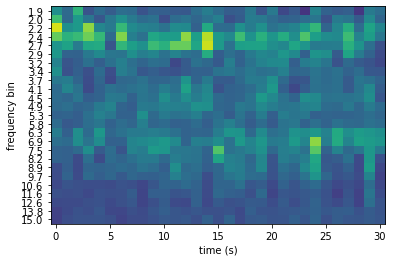

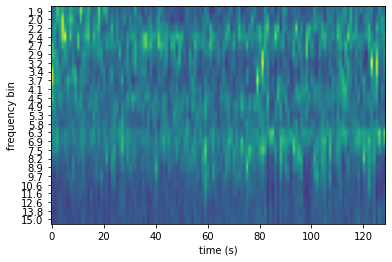

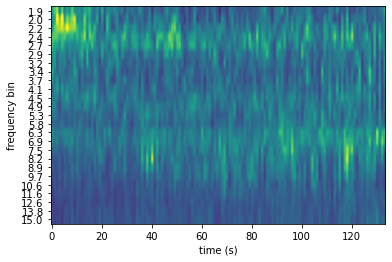

In [13]:
%matplotlib inline

dot_toUse = 1200

# avg_trace = np.zeros((data_tensor.shape[1] , 3))
for ii , val in enumerate(np.array([4,5,6])):
    data_toPlot = np.mean(data_tensor_trIdx[dot_toUse,:,0,:,np.where(trLab==val)[0]] , axis=2).T
#     data_toPlot = np.reshape(data_tensor_trIdx[dot_toUse,:,0,:,np.where(trLab==val)[0]].transpose(1,2,0) , (dts[1] , dts[3]*np.sum(trLab==val)))
#     data_toPlot = np.mean(data_tensor_trIdx[dot_toUse,:,0,:,np.where(trLab==val)[0]] , axis=0)
#     data_toPlot = data_toPlot[:,np.arange(0,data_toPlot.shape[1] , 3)]
    plt.figure()
    plt.imshow(data_toPlot,
               aspect='auto')
    plt.xlabel('time (s)')
    plt.ylabel('frequency bin')
    plt.yticks(np.arange(len(freqs_Sxx)), np.round(freqs_Sxx,1))
    plt.clim(0,0.15)
    
#     avg_trace[:,ii] = np.mean(data_toPlot , axis=1)
    
# plt.figure()
# plt.plot(avg_trace)

In [14]:
# import trial data
import pandas as pd
import numpy as np
from pathlib import Path

trIdx_fileName = r'SM115_20201204_trial_indices.csv'
trIdx_dir = Path('/media/rich/bigSSD RH/other lab data/uchida lab/sara').resolve()
trIdx_path = trIdx_dir / trIdx_fileName
trIdx = np.array(pd.read_csv(trIdx_path, sep=',',header=None)).T

trLab_fileName = r'SM115_20201204_trial_types.csv'
trLab_dir = Path('/media/rich/bigSSD RH/other lab data/uchida lab/sara').resolve()
trLab_path = trLab_dir / trLab_fileName
trLab = np.array(pd.read_csv(trLab_path, sep=',',header=None))


In [15]:
# trialsToUse = np.where((trLab==4) + (trLab==5) + (trLab==6))[0]
trialsToUse = np.where((trLab==4) + (trLab==5))[0]
n_trialsToUse = len(trialsToUse)

In [16]:
from pathlib import Path

dir_save = Path(r'/media/rich/bigSSD RH/other lab data/uchida lab/sara').resolve()
fileName_save = r'data_tensor_crop_45.npy'
path_save = dir_save / fileName_save

In [4]:
data_tensor_crop = np.load(path_save)

In [18]:
import copy
trLab_metric = copy.deepcopy(trLab)
trLab_metric[trLab < 4] = 9999
trLab_metric[trLab==4] = -1
trLab_metric[trLab==5] = 1
trLab_metric[trLab==6] = 999

In [46]:
import tensorly as tl
from tensorly.regression.cp_regression import CPRegressor
from tensorly.regression.tucker_regression import TuckerRegressor
import sklearn as sk
import sklearn.model_selection

tl.set_backend('pytorch')

X_input = data_tensor_crop.transpose(4,0,1,2,3)
X_input = X_input[:,np.arange(0,X_input.shape[1],6),...]
y_input = trLab_metric[trialsToUse][:,0]

X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(
    X_input, y_input, test_size=0.3, random_state=0)

In [51]:
X = tl.tensor(X_train).to('cuda')
y = tl.tensor(y_train).to('cuda')

rank = 3

# Create a tensor Regressor estimator
estimator = CPRegressor(weight_rank=rank, tol=10e-8, n_iter_max=1000, reg_W=10**(0.5), verbose=1)
# estimator = TuckerRegressor(weight_ranks=[1, 1], tol=10e-7, n_iter_max=100, reg_W=1, verbose=1)

# Fit the estimator to the data
estimator.fit(X, y)

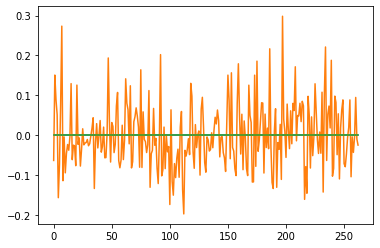

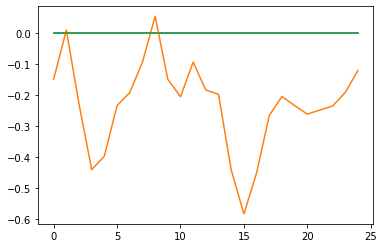

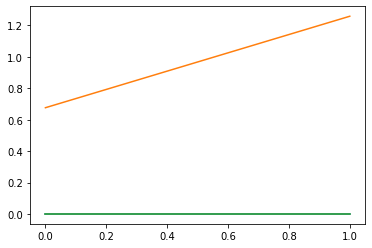

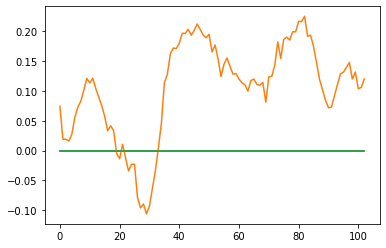

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt
for ii in range(4):
    plt.figure()
    plt.plot(estimator.cp_weight_[1][ii].cpu())

In [53]:
def find_pred_stats(labels , preds, *args):
    if 'label_vals' not in locals():
        label_vals = np.unique(labels)
    pred_avg = np.zeros(len(label_vals))
    pred_std = np.zeros(len(label_vals))
    pred_sem = np.zeros(len(label_vals))
    for ii,val in enumerate(label_vals):
        pred_avg[ii] = np.mean(np.array(preds)[np.where(labels==val)[0]] , axis=0)
        pred_std[ii] = np.std(np.array(preds)[np.where(labels==val)[0]] , axis=0)
        pred_sem[ii] = pred_std[ii]/np.sqrt(len(np.array(preds)[np.where(labels==val)[0]]))
    return pred_avg , pred_std , pred_sem , label_vals

prediction averages: [0.05002894 0.63861459]
R = 0.3181448352497318
p-value = nan


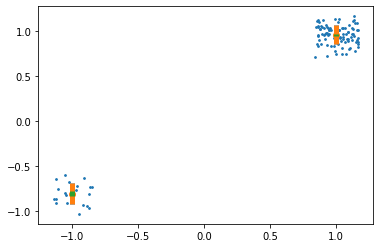

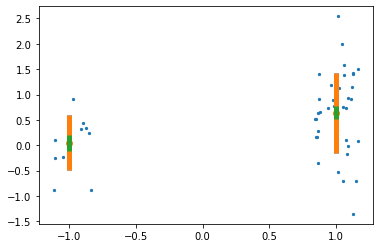

In [54]:
import scipy.stats

%matplotlib inline

X = tl.tensor(X_train).to('cuda')
pred = estimator.predict(X)
pred_avg , pred_std , pred_sem , label_vals = find_pred_stats(y_train , pred.cpu() , np.unique(y_input))

plt.figure()
plt.scatter(y_train + (np.random.rand(len(pred))-0.5)/3 , pred.cpu(), s=3)
plt.scatter(label_vals , pred_avg)
# plt.errorbar(label_vals , pred_avg , yerr=pred_std , '.' , color='r')
plt.errorbar(label_vals , pred_avg , yerr=pred_std , linewidth=0 , elinewidth=5)
plt.errorbar(label_vals , pred_avg , yerr=pred_std , linewidth=0 , elinewidth=5)
plt.errorbar(label_vals , pred_avg , yerr=pred_sem , linewidth=0 , elinewidth=5)

X = tl.tensor(X_test).to('cuda')
pred_test = estimator.predict(X)
pred_avg , pred_std , pred_sem , label_vals = find_pred_stats(y_test , pred_test.cpu() , np.unique(y_input))

plt.figure()
plt.scatter(y_test + (np.random.rand(len(pred_test))-0.5)/3 , pred_test.cpu(), s=5)
plt.scatter(label_vals , pred_avg)
plt.errorbar(label_vals , pred_avg , yerr=pred_std , linewidth=0 , elinewidth=5)
plt.errorbar(label_vals , pred_avg , yerr=pred_std , linewidth=0 , elinewidth=5)
plt.errorbar(label_vals , pred_avg , yerr=pred_sem , linewidth=0 , elinewidth=5)

dist1 = pred_test[np.where(y_test==1)[0]].cpu()
dist2 = pred_test[np.where(y_test==2)[0]].cpu()
t_stat, pval = scipy.stats.ttest_ind(dist1 , dist2)

print(f'prediction averages: {pred_avg}')
print(f'R = {np.corrcoef(pred_test.cpu() , y_test)[0,1]}')
print(f'p-value = {pval}')


In [121]:
X_4 = data_tensor_crop.transpose(4,0,1,2,3)
X_4 = X_4[:,np.arange(0,X_4.shape[1],4),...]
y_4 = np.where(y_input==4)[0]

X = tl.tensor(X_4[y_4]).to('cuda')
pred_test = estimator.predict(X)
pred_avg , pred_std , pred_sem , label_vals = find_pred_stats(y_4 , pred_test.cpu() , np.unique(y_input))

plt.figure()
plt.scatter(y_4 + (np.random.rand(len(pred_test))-0.5)/3 , pred_test.cpu(), s=5)
plt.scatter(label_vals , pred_avg)
plt.errorbar(label_vals , pred_avg , yerr=pred_sem , linewidth=0 , elinewidth=5)
plt.errorbar(label_vals , pred_avg , yerr=pred_sem , linewidth=0 , elinewidth=5)

dist1 = pred_test[np.where(y_test==-1)[0]].cpu()
dist2 = pred_test[np.where(y_test==1)[0]].cpu()
t_stat, pval = scipy.stats.ttest_ind(dist1 , dist2)
print(f'p-value = {pval}')

print(f'prediction averages: {pred_avg}')
print(f'R = {np.corrcoef(pred_test.cpu() , y_test)[0,1]}')

RuntimeError: cannot reshape tensor of 0 elements into shape [0, -1] because the unspecified dimension size -1 can be any value and is ambiguous

In [216]:
data_tensor_crop.transpose(4,0,1,2,3).shape

(294, 1575, 25, 2, 103)

In [238]:
X_4 = data_tensor_crop.transpose(4,0,1,2,3)
# X_4 = X_4[:,np.arange(0,X_4.shape[1],4),...]

X_train.shape
X_4.shape
# data_tensor_crop.shape

(294, 1575, 25, 2, 103)

In [7]:
import sys
sys.getsizeof(data_tensor_crop)/1e9

8.53303516

In [30]:
import tensorly as tl
from tensorly.decomposition import non_negative_parafac_hals , non_negative_parafac
tl.set_backend('pytorch')

data_input = tl.tensor(data_tensor_crop).to('cuda')
test = non_negative_parafac_hals(data_input, 6, n_iter_max=100, init='random', tol=1e-08)

/home/rich/miniconda3/envs/torch_env/lib/python3.8/site-packages/tensorly/backend/pytorch_backend.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data, dtype=dtype, device=device,


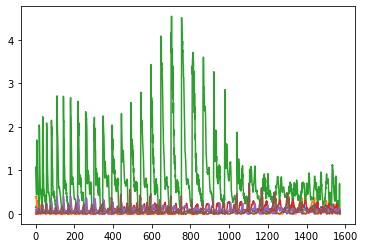

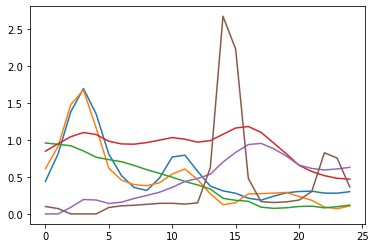

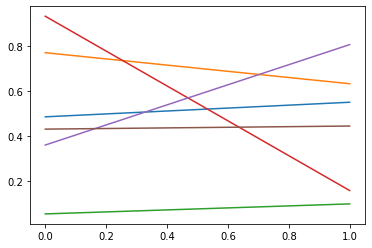

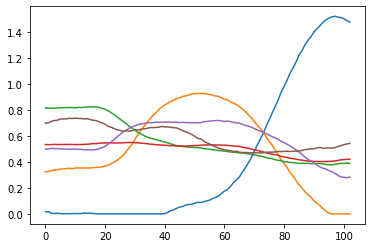

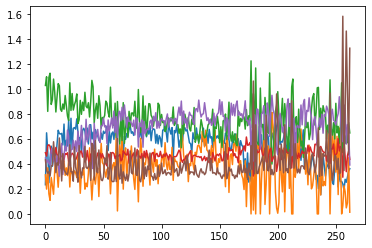

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
for ii in range(5):
    plt.figure()
    plt.plot(test[1][ii].cpu())

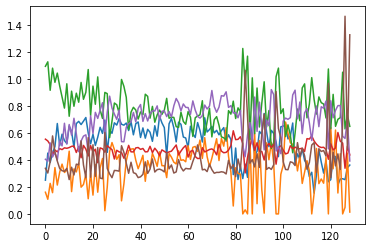

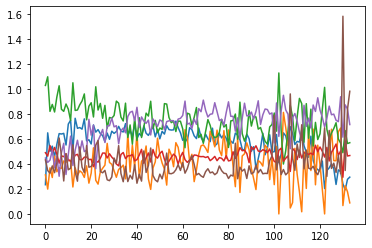

In [32]:
plt.figure()
plt.plot(
    test[1][4].cpu()[
    np.where(trLab[trialsToUse][:,0]==5)[0],
    :])
plt.figure()
plt.plot(test[1][4].cpu()[
    np.where(trLab[trialsToUse][:,0]==6)[0],
    :])

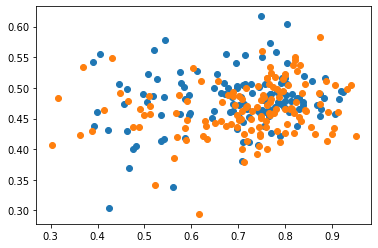

In [36]:
plt.figure()
plt.scatter(test[1][4].cpu()[
    np.where(trLab[trialsToUse][:,0]==5)[0], 4 ]  ,
           test[1][4].cpu()[
    np.where(trLab[trialsToUse][:,0]==5)[0], 3 ] )
plt.scatter(test[1][4].cpu()[
    np.where(trLab[trialsToUse][:,0]==6)[0], 4 ]  ,
           test[1][4].cpu()[
    np.where(trLab[trialsToUse][:,0]==6)[0], 3 ] )

In [52]:
y

array([ 1,  1,  1, -1, -1,  1, -1, -1, -1,  1,  1, -1,  1,  1,  1,  1,  1,
       -1, -1, -1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1, -1, -1, -1, -1,
       -1,  1, -1,  1,  1, -1, -1,  1, -1,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  1,  1, -1,  1, -1, -1,  1, -1,  1,  1, -1,  1,  1,  1,  1, -1,
       -1, -1,  1,  1, -1,  1,  1, -1,  1,  1, -1,  1, -1,  1,  1,  1, -1,
        1, -1, -1, -1,  1,  1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1,  1,
        1,  1, -1, -1, -1, -1, -1,  1, -1, -1,  1, -1, -1, -1,  1,  1,  1,
       -1,  1, -1,  1,  1, -1, -1, -1, -1,  1, -1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1, -1,  1, -1, -1, -1,  1, -1, -1,  1, -1, -1,  1,
        1,  1,  1,  1, -1,  1,  1,  1, -1, -1,  1, -1, -1,  1,  1, -1, -1,
        1,  1,  1, -1, -1, -1, -1, -1,  1, -1,  1, -1,  1,  1, -1, -1,  1,
        1, -1, -1,  1,  1, -1,  1,  1,  1,  1,  1, -1,  1, -1,  1,  1,  1,
        1, -1,  1, -1,  1, -1,  1, -1, -1, -1,  1, -1, -1, -1,  1, -1,  1,
       -1, -1, -1, -1, -1

In [51]:
import sklearn as sk
import sklearn.model_selection
import copy
import time

X_input = np.array(test[1][4].cpu())
X = np.hstack((np.ones(X_input.shape[0]).reshape(X_input.shape[0],1) , X_input))

y = trLab[trialsToUse][:,0]
y[np.where(y==5)[0]] = -1
y[np.where(y==6)[0]] = 1

X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(
    X, y, test_size=0.3, random_state=0)

### SKLEARN regression
# # clf = sklearn.linear_model.LinearRegression()
# clf = sklearn.linear_model.Lasso(alpha=L1_alpha)
# # clf = sklearn.linear_model.ElasticNet(alpha=1 , l1_ratio=0)
# clf.fit(X_train , y_train )
# theta = clf.coef_


theta = copy.deepcopy(np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train)

y_train_output = X_train @ theta
R_train = (np.corrcoef(y_train_output, y_train))[1,0]
print(f'train R: {R_train}')

y_test_output = X_test @ theta
R_test = (np.corrcoef(y_test_output, y_test))[1,0]
print(f'test  R: {R_test} , test  R^2: {R_test**2}')

#     y_reconstructed[:,iter_factor] = X @ theta_FF[:,iter_factor]
#     y_reconstructed_FF[:,iter_factor] = np.hstack((np.ones(F_zscore_roll.shape[0]).reshape(F_zscore_roll.shape[0],1) , F_zscore_roll[:,IsCell_ROIClassifier==True])) @ theta_FF[:,iter_factor]
y_reconstructed = X @ theta

train R: 0.27045427412781803
test  R: 0.2232808086091588 , test  R^2: 0.049854319493159806


In [47]:
np.hstack((np.ones(X.shape[0]).reshape(X.shape[0],1) , X)).shape

(263, 8)

In [21]:
import copy

estimator_run1 # [-1 , 0 , 1]
estimator_run2 # [1 , 3 , 2]
estimator_run1 = copy.deepcopy(estimator)

In [27]:
import torch
torch.cuda.empty_cache()

TypeError: Invalid shape (1575, 2, 308) for image data

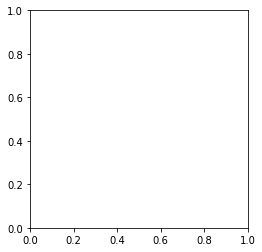

In [63]:
# ax = fig.add_subplot(n_rows, n_columns, i*n_columns + j + 2)
plt.figure()
plt.imshow(tl.to_numpy(estimator.weight_tensor_),
#           cmap=plt.cm.OrRd,
#           interpolation='nearest'
         )